**BANGKIT MACHINE LEARNING OIL SCANNING**

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow=="2.13.0"

Found existing installation: tensorflow 2.13.0
Uninstalling tensorflow-2.13.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.13.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.13.0
  Using cached tensorflow-2.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (524.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.13.0 which is incompatible.


In [ ]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 30.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, regularizers, Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow import lite
import warnings
warnings.filterwarnings("ignore")

**VISUALIZATION IMAGES**

Exception ignored in: <function _xla_gc_callback at 0x792d91c71cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


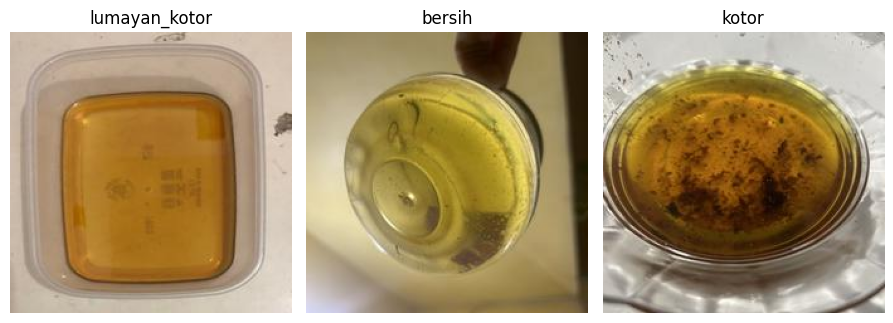

In [ ]:
train_path = '/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/split dataset/reoil/training'
class_names = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]

# Function untuk load and menampilkan image dengan label (mnenggunakan error handling)
def display_image(path, label):
    try:
        # Read image menggunakan OpenCV
        img = cv2.imread(path)
        if img is None:
            raise Exception(f"Error reading image: {path}")
        # Convert ke RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Error processing image: {path} ({e})")
        return None
    # Calculate nomor dari baris yang dibutuhkan di grid
num_classes = len(class_names)
num_cols = 4
num_rows = (num_classes + num_cols - 1) // num_cols  # Ceiling division to ensure all classes fit

# Create figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12,10))  # Adjust figsize for better visualization
axes = np.atleast_2d(axes)  # Ensure axes is always 2-dimensional

# Display one image for each class
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_path, class_name)
    images = []

    # Collect images from subfolders, if present
    subfolders = [subfolder for subfolder in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, subfolder))]
    if subfolders:
        for subfolder in subfolders:
            subfolder_path = os.path.join(class_path, subfolder)
            images.extend([os.path.join(subfolder_path, img) for img in os.listdir(subfolder_path) if img.endswith(('jpg', 'png', 'jpeg'))])
    else:
        # Collect images directly from class folder if no subfolders
        images.extend([os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('jpg', 'png', 'jpeg'))])

    if images:
        image_path = random.choice(images)  # Randomly select one image
        img = display_image(image_path, class_name)
        ax = axes[idx // num_cols, idx % num_cols]
        if img is not None:  # Check jika image telah berhasil terload
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name)
        else:
            ax.text(0.5, 0.5, "Error", ha='center', va='center', color='red')
            ax.axis('off')
    else:
        ax = axes[idx // num_cols, idx % num_cols]
        ax.text(0.5, 0.5, "No images", ha='center', va='center', color='red')
        ax.axis('off')

# Hide any empty subplots
for i in range(num_classes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and display figure
fig.tight_layout()
plt.show()

**PREPROCESSING DATA**

In [ ]:
train_path = '/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/split dataset/reoil/training'
val_path = '/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/split dataset/reoil/validation'
test_path = '/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/split dataset/reoil/testing'

In [ ]:
#checking bad image
def check_images(path):
     for subdir, dirs, files in os.walk(path):
         for file in files:
             file_path = os.path.join(subdir, file)
             try:
                 img = Image.open(file_path) # open image file
                 img.verify() # image verification
             except (IOError, SyntaxError) as e:
                 print('Bad file:', file_path)

check_images(train_path)
check_images(val_path)
check_images(test_path)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# ImageDataGenerator for data augmentation and normalization
train_generator = ImageDataGenerator(
    rescale=1.0/255.,
    width_shift_range=0.2,  # Menggeser gambar secara horizontal
    height_shift_range=0.2,  # Menggeser gambar secara vertikal
    zoom_range=0.2,  # Melakukan zoom in dan zoom out pada gambar
    horizontal_flip=False,  # Membalik gambar secara horizontal
    shear_range=0.2,  # Melakukan transformasi shear pada gambar
    rotation_range=30,  # Memutar gambar dengan sudut acak dalam rentang yang ditentukan
    fill_mode='nearest',  # Strategi yang digunakan untuk mengisi piksel yang mungkin muncul setelah rotasi atau pergeseran lebar/tinggi
    brightness_range=[0.8, 1.2],
    )

train_image_generator = train_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

val_generator = ImageDataGenerator(rescale=1.0/255)
val_image_generator = val_generator.flow_from_directory(
    val_path,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = ImageDataGenerator(rescale=1./255.)

testing_image_generator = testing_generator.flow_from_directory(directory=test_path,
                                                            batch_size=32,
                                                            class_mode='categorical',
                                                            shuffle=True,
                                                            target_size=(224, 224))

#class weight
classes = np.unique(train_image_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_image_generator.classes)

class_weights = dict(enumerate(class_weights))

Found 202 images belonging to 3 classes.
Found 42 images belonging to 3 classes.
Found 47 images belonging to 3 classes.


In [ ]:
# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
for key, value in class_map.items():
    print(f"{key} : {value}")

0 : bersih
1 : kotor
2 : lumayan_kotor


**TRANSFER LEARNING TEST**

In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

In [ ]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)

input_14
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expan

In [ ]:
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

i. Build Model

In [ ]:
import tensorflow as tf

# Create the complete model
#model = tf.keras.Model(inputs, outputs)
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

ii. Model Diagram

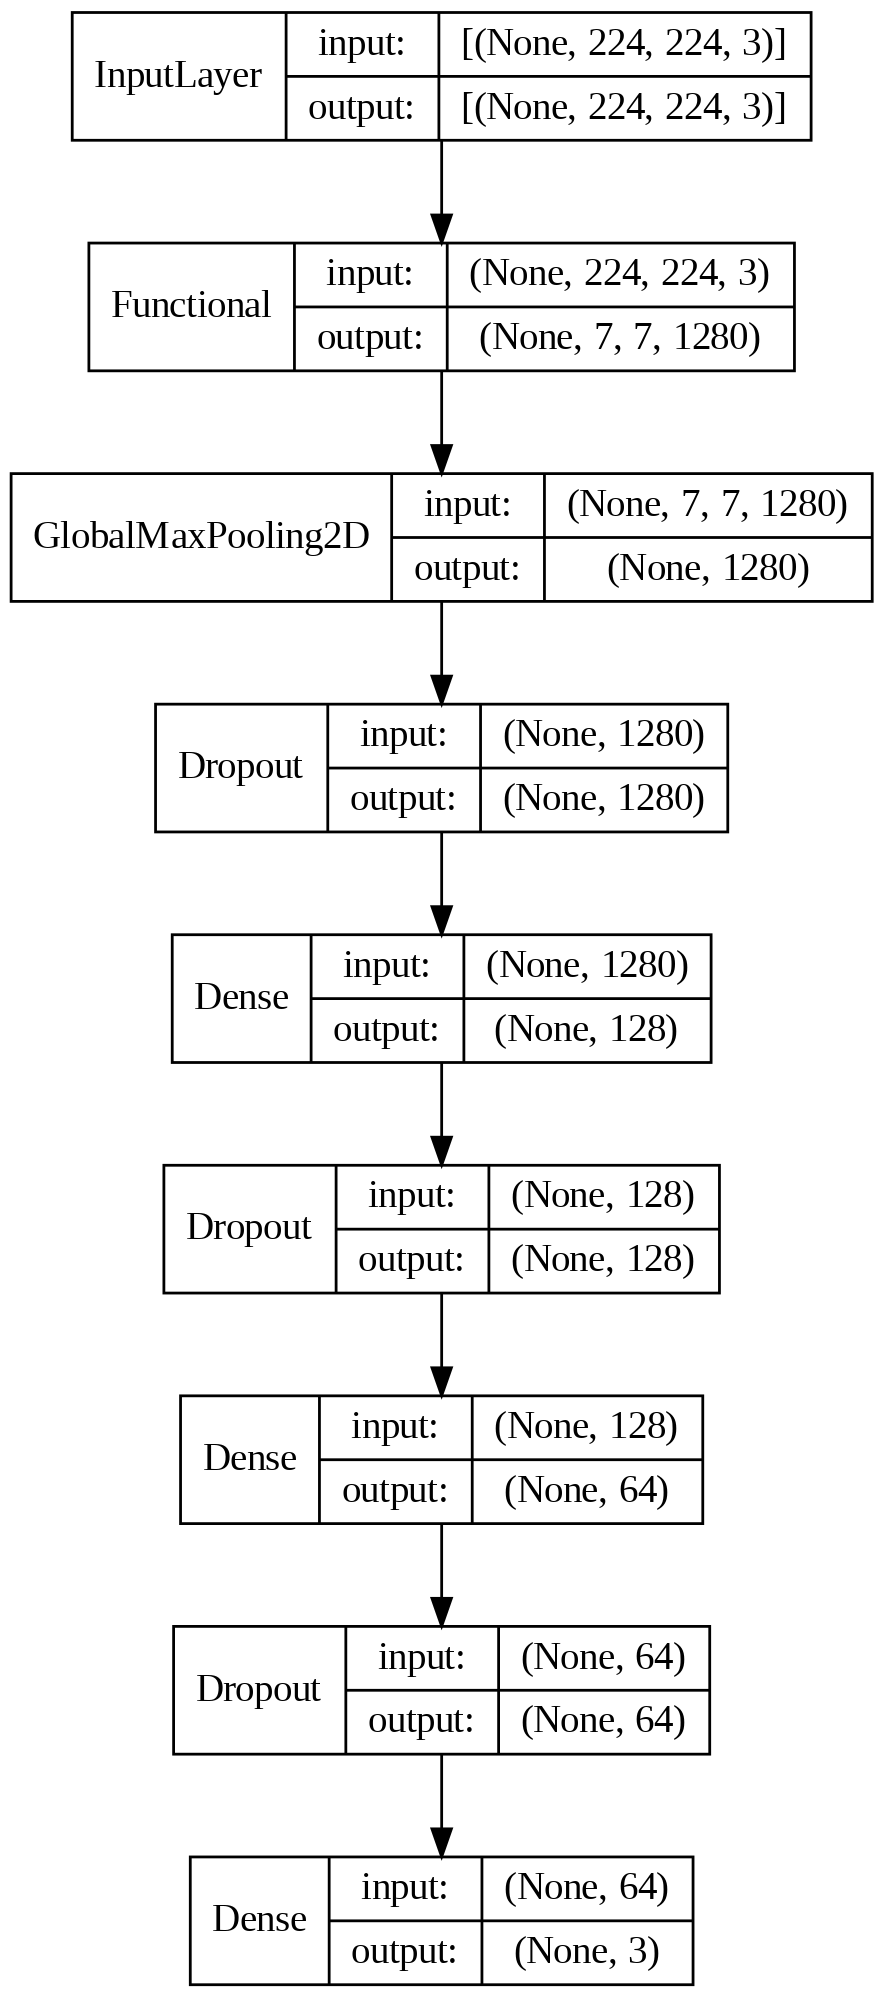

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_8 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dropout_20 (Dropout)        (None, 1280)              0         
                                                                 
 dense_35 (Dense)            (None, 128)               163968    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 64)              

iii. Model Compile

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Learning rate schedule / reduce learning rate
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy',
                               factor=0.5,
                               patience=10,
                               min_lr=0.000001)

#lr_scheduler_lambda = LearningRateScheduler(lambda epoch: 1e-4 * 0.9 ** epoch)

# # Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy',patience=10,mode='max',restore_best_weights=True)

# chekpoint for mining top value
checkpoint = ModelCheckpoint('checkpoint_model.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

callbacks = [checkpoint, lr_schedule, early_stopping]

**MODEL TRAINING**

In [ ]:
history = model.fit(train_image_generator,
                    validation_data=val_image_generator,
                    epochs=100,
                    verbose=1,
                    callbacks=callbacks,
                    class_weight=class_weights)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 8.6486 - accuracy: 0.4703
Epoch 1: val_accuracy improved from -inf to 0.59524, saving model to checkpoint_model.h5
7/7 [==============================] - 73s 11s/step - loss: 8.6486 - accuracy: 0.4703 - val_loss: 5.3185 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 5.8218 - accuracy: 0.6535
Epoch 2: val_accuracy improved from 0.59524 to 0.61905, saving model to checkpoint_model.h5
7/7 [==============================] - 17s 2s/step - loss: 5.8218 - accuracy: 0.6535 - val_loss: 4.6070 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 5.1527 - accuracy: 0.5891
Epoch 3: val_accuracy did not improve from 0.61905
7/7 [==============================] - 16s 2s/step - loss: 5.1527 - accuracy: 0.5891 - val_loss: 4.7086 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 4

**FINE-TUNING**

In [ ]:
# Membuka beberapa layer terakhir dari pre-trained model untuk fine-tuning
for layer in pre_trained_model.layers[-5:]:
    layer.trainable = True

# Compile ulang model dengan learning rate yang lebih rendah
from tensorflow.keras.optimizers import Adam

fine_tune_lr = 1e-5
model.compile(optimizer=Adam(learning_rate=fine_tune_lr), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks untuk fine-tuning
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
checkpoint_fine = ModelCheckpoint('checkpoint_model_fine_tuned.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', save_format='h5')
early_stopping_fine = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

callbacks=[lr_reduce, checkpoint_fine, early_stopping_fine]
# Pelatihan model fine-tuning
history_fine = model.fit(
    train_image_generator,
    validation_data=val_image_generator,
    epochs=50,  # Jumlah epoch untuk fine-tuning, bisa disesuaikan
    verbose=1,
    callbacks=callbacks
)


Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 2.1152 - accuracy: 0.9455
Epoch 1: val_accuracy improved from -inf to 0.78571, saving model to checkpoint_model_fine_tuned.h5
7/7 [==============================] - 23s 2s/step - loss: 2.1152 - accuracy: 0.9455 - val_loss: 3.7315 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 2.1015 - accuracy: 0.9158
Epoch 2: val_accuracy did not improve from 0.78571
7/7 [==============================] - 16s 2s/step - loss: 2.1015 - accuracy: 0.9158 - val_loss: 3.7406 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 2.1236 - accuracy: 0.9208
Epoch 3: val_accuracy did not improve from 0.78571
7/7 [==============================] - 16s 2s/step - loss: 2.1236 - accuracy: 0.9208 - val_loss: 3.7528 - val_accuracy: 0.7857 - lr: 1.0000e-05
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 2.0907 - accuracy: 0.925

**MODEL VISUALIZATION**

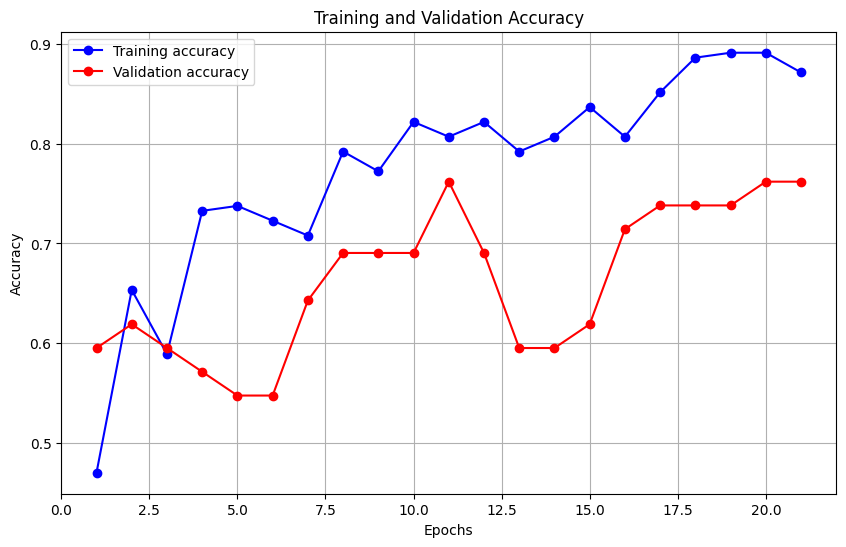

In [ ]:
result_data = pd.DataFrame(history.history)
result_data.tail()

# Ekstrak akurasi dan akurasi validasi dari objek history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plot akurasi pelatihan dan validasi
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model
checkpoint_model = load_model('/content/checkpoint_model.h5')

# Evaluate the best model on the training and validation data
train_results = checkpoint_model.evaluate(train_image_generator)
val_results = checkpoint_model.evaluate(val_image_generator)

# Print the evaluation results
print("Training Loss:", train_results[0])
print("Training Accuracy:", train_results[1])
print("Validation Loss:", val_results[0])
print("Validation Accuracy:", val_results[1])

2/2 [==============================] - 2s 302ms/step - loss: 3.7983 - accuracy: 0.7619
Training Loss: 2.6495821475982666
Training Accuracy: 0.801980197429657
Validation Loss: 3.798312187194824
Validation Accuracy: 0.761904776096344


**MODEL SAVING**

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/my_model.keras')

In [ ]:
model.save_weights('/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/my_model_weights.h5')

In [ ]:
# Convert h5 keras file to tflite for app integration
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/CAPSTONE_2024/data/MINYAK/my_model.keras')

for layer in model.layers:
    print(layer.name)

mobilenetv2_1.00_224
global_max_pooling2d_8
dropout_20
dense_35
dropout_21
dense_36
dropout_22
dense_37


In [ ]:
# Rename the input layer
model.get_layer('mobilenetv2_1.00_224')._name = 'mobilenetv2_1_00_224_input'

In [ ]:
# Convert model to TensorFlow Lite
converter = lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()

In [ ]:
# Save the TFLite Model
with open("Minyaq.tflite", "wb") as f:
  f.write(tflite_model)
print('Model converted successfully')

Model converted successfully
